In [1]:
import sys

sys.path.append('../')

%load_ext autoreload
%autoreload 1
%aimport HEEM_VQE_Functions

/home/dfernandez/anaconda3/envs/heem/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

import warnings
from qiskit import IBMQ, transpile

from HEEM_VQE_Functions import measure_circuit_factor

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    IBMQ.load_account()

ibmqfactory.load_account:WARNING:1970-05-10 07:39:57,498: Credentials are already in use. The existing account in the session will be replaced.


In [41]:
molecules = ['H2', 'LiH', 'BeH2', 'H2O', 'CH4', 'C2H2']
groupings = ['EM', 'HEEM']

device_name = 'ibmq_montreal'
provider = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic')
backend = provider.get_backend(device_name)

n_qubits = {}
n_cnots_dic = {'HEEM': {}, 'EM': {}}

for molecule in molecules:
    data = np.load('../data/optimal_grouping_' + molecule + '_' + device_name + '.npy', allow_pickle=True).item()
    n_qubits[molecule] = data['qubit_op'].num_qubits
    print('Molecule: ', molecule, '({} qubits)'.format(n_qubits[molecule]))
    
    for grouping in groupings:
        print('  Grouping:', grouping)
        
        num_qubits = len(data[grouping]['T'])
        circuits = [measure_circuit_factor(measure, num_qubits) for measure in data[grouping]['Measurements']]

        circuits_transpiled = transpile(circuits, backend, initial_layout=data[grouping]['T'][::-1])

        n_cnots = 0
        for circuit in circuits_transpiled:
            try:
                n_cnots += circuit.count_ops()['cx']
            except KeyError:
                pass
        
        n_cnots_dic[grouping][molecule] = n_cnots
        
        print('    Number of groups: ', len(data[grouping]['Groups']))
        print('    Number of CNOTs: ', n_cnots)
    print('-' * 27)

Molecule:  H2 (2 qubits)
  Grouping: EM
    Number of groups:  2
    Number of CNOTs:  1
  Grouping: HEEM
    Number of groups:  2
    Number of CNOTs:  1
---------------------------
Molecule:  LiH (4 qubits)
  Grouping: EM
    Number of groups:  10
    Number of CNOTs:  8
  Grouping: HEEM
    Number of groups:  10
    Number of CNOTs:  8
---------------------------
Molecule:  BeH2 (6 qubits)
  Grouping: EM
    Number of groups:  11
    Number of CNOTs:  74
  Grouping: HEEM
    Number of groups:  16
    Number of CNOTs:  18
---------------------------
Molecule:  H2O (8 qubits)
  Grouping: EM
    Number of groups:  41
    Number of CNOTs:  563
  Grouping: HEEM
    Number of groups:  50
    Number of CNOTs:  80
---------------------------
Molecule:  CH4 (10 qubits)
  Grouping: EM
    Number of groups:  101
    Number of CNOTs:  2677
  Grouping: HEEM
    Number of groups:  138
    Number of CNOTs:  224
---------------------------
Molecule:  C2H2 (16 qubits)
  Grouping: EM
    Number of gr

Text(0, 0.5, '# CNOTs')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
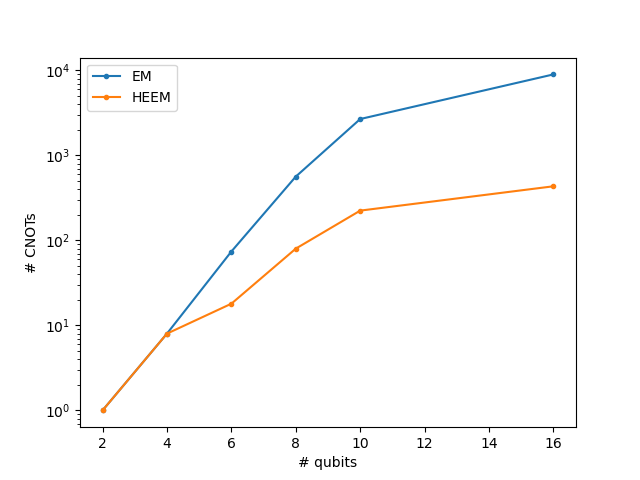

In [46]:
fig, ax = plt.subplots()

for grouping in groupings:
    y_cnots = []
    x_cnots = []
    for molecule in molecules:
        x_cnots.append(n_qubits[molecule])
        y_cnots.append(n_cnots_dic[grouping][molecule])
    ax.plot(x_cnots, y_cnots,label=grouping, marker='.')

ax.legend()
ax.set_yscale('log')

ax.set_xlabel('# qubits')
ax.set_ylabel('# CNOTs')